# Анализ сервиса аренды самокатов GoFast



<p>Вы аналитик популярного сервиса аренды самокатов GoFast. Вам передали данные о некоторых пользователях из нескольких городов, а также об их поездках. Проанализируйте данные и проверьте некоторые гипотезы, которые могут помочь бизнесу вырасти.</p>

<p>Чтобы совершать поездки по городу, пользователи сервиса GoFast пользуются мобильным приложением. Сервисом можно пользоваться:</p>

<ul>
	<li>без подписки
	<ul>
		<li>абонентская плата отсутствует;</li>
		<li>стоимость одной минуты поездки &mdash; 8 рублей;</li>
		<li>стоимость старта (начала поездки) &mdash; 50 рублей;</li>
	</ul>
	</li>
	<li>с подпиской Ultra
	<ul>
		<li>абонентская плата &mdash; 199 рублей в месяц;</li>
		<li>стоимость одной минуты поездки &mdash; 6 рублей;</li>
		<li>стоимость старта &mdash; бесплатно.</li>
	</ul>
	</li>
</ul>

<p><strong>Описание данных</strong></p>

<p><strong>Пользователи &mdash;&nbsp;<code>users_go.csv</code></strong></p>

<ul>
	<li><code>user_id</code>&nbsp;&mdash; уникальный идентификатор пользователя</li>
	<li><code>name</code>&nbsp;&mdash; имя пользователя</li>
	<li><code>age</code>&nbsp;&mdash; возраст</li>
	<li><code>city</code>&nbsp;&mdash; город</li>
	<li><code>subscription_type</code>&nbsp;&mdash; тип подписки (free, ultra)</li>
</ul>

<p><strong>Поeздки &mdash;&nbsp;<code>rides_go.csv</code></strong></p>

<ul>
	<li><code>user_id</code>&nbsp;&mdash; уникальный идентификатор пользователя</li>
	<li><code>distance</code>&nbsp;&mdash; расстояние, которое пользователь проехал в текущей сессии (в метрах)</li>
	<li><code>duration</code>&nbsp;&mdash; продолжительность сессии (в минутах) &mdash; время с того момента, как пользователь нажал кнопку &laquo;Начать поездку&raquo; до момента, как он нажал кнопку &laquo;Завершить поездку&raquo;</li>
	<li><code>date</code>&nbsp;&mdash; дата совершения поездки</li>
</ul>

<p><strong>Подписки &mdash;&nbsp;<code>subscriptions_go.csv</code></strong></p>

<ul>
	<li><code>subscription_type</code>&nbsp;&mdash; тип подписки</li>
	<li><code>minute_price</code>&nbsp;&mdash; стоимость одной минуты поездки по данной подписке</li>
	<li><code>start_ride_price</code>&nbsp;&mdash; стоимость начала поездки</li>
	<li><code>subscription_fee</code>&nbsp;&mdash; стоимость ежемесячного платежа</li>
</ul>


# План работы

<ul>
	<li>
	Шаг 1. Загрузка данных
	</li>
	<li>Шаг 2. Предобработка данных</li>
	<li>Шаг 3. Исследовательский анализ данных</li>
	<li>Шаг 4. Объединение данных</li>
	<li>Шаг 5. Подсчёт выручки</li>
	<li>Шаг 6. Проверка гипотез</li>
	<li>Шаг 7. Распределения</li>
</ul>


## Шаг 1. Загрузка данных

In [105]:

import pandas as pd
import matplotlib.pyplot as plt
import math
import numpy as np
import copy
import seaborn as sns
import plotly.express as px
import matplotlib.ticker as ticker
from scipy import stats as st
from scipy.stats import ttest_ind
from scipy.stats import ttest_1samp
from scipy import stats
from scipy.stats import binom
from scipy.stats import norm

sns.set_theme(style="whitegrid")
pd.options.display.float_format = '{:,.1f}'.format

In [3]:
users = pd.read_csv('/datasets/users_go.csv')
rides = pd.read_csv('/datasets/rides_go.csv')
subs = pd.read_csv('/datasets/subscriptions_go.csv')

###  Таблица "Пользователи"

In [4]:
display(users.sample(10))

,user_id,name,age,city,subscription_type
324,325,Софья,26,Пятигорск,ultra
1102,1103,Вадим,21,Краснодар,free
918,919,Марат,24,Краснодар,free
190,191,Марсель,23,Омск,ultra
111,112,Святослав,24,Краснодар,ultra
1527,1528,Анна,25,Пятигорск,free
436,437,Любовь,28,Тюмень,ultra
1419,1420,Юлия,18,Краснодар,free
1445,1446,Камилла,28,Ростов-на-Дону,free
1431,1432,Федор,23,Тюмень,free


In [5]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1565 entries, 0 to 1564
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   user_id            1565 non-null   int64 
 1   name               1565 non-null   object
 2   age                1565 non-null   int64 
 3   city               1565 non-null   object
 4   subscription_type  1565 non-null   object
dtypes: int64(2), object(3)
memory usage: 61.3+ KB


###  Таблица "Поездки"

In [6]:
display(rides.sample(10))

,user_id,distance,duration,date
16378,1415,428.1,6.2,2021-07-12
6117,656,"3,520.3",23.1,2021-03-05
16848,1446,"2,814.9",16.8,2021-11-19
11901,1094,"2,568.2",9.7,2021-10-05
16087,1395,"5,029.5",22.6,2021-11-06
17268,1478,"2,116.9",13.8,2021-12-30
902,96,"2,847.7",17.2,2021-05-08
16032,1392,"3,539.9",17.6,2021-04-18
4520,487,"2,952.5",9.6,2021-08-07
10889,1021,"2,365.1",14.1,2021-03-10


In [7]:
rides.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   user_id   18068 non-null  int64  
 1   distance  18068 non-null  float64
 2   duration  18068 non-null  float64
 3   date      18068 non-null  object 
dtypes: float64(2), int64(1), object(1)
memory usage: 564.8+ KB


###  Таблица "Подписки"


In [8]:
display(subs)

,subscription_type,minute_price,start_ride_price,subscription_fee
0,free,8,50,0
1,ultra,6,0,199


In [9]:
subs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   subscription_type  2 non-null      object
 1   minute_price       2 non-null      int64 
 2   start_ride_price   2 non-null      int64 
 3   subscription_fee   2 non-null      int64 
dtypes: int64(3), object(1)
memory usage: 192.0+ bytes


### Вывод 

<p><strong>Загрузка и предварительный анализ данных</strong>:</p>

<ul>
	<li>Данные были успешно загружены и проанализированы.</li>
	<li>В данных не обнаружено пропущенных значений.</li>
    <li>Таблица "Пользователи" содержит 1565 строк</li>
    <li>Таблица "Поездки" содержит 18086 строк</li>
    <li>Таблица "Подписки" сожержит общую информацию по тарифам</li>
    
</ul>

<p>После первичного знакомства с данными таблицы &quot;Пользователи&quot; можно сделать следующие выводы:</p>

<ul>
	<li>В таблице содержится информация о 1565 пользователях.</li>
	<li>Все столбцы содержат данные без пропущенных значений.</li>
	<li>Столбец user_id представляет собой идентификаторы пользователей и имеет тип данных int64.</li>
	<li>Столбец name содержит имена пользователей и имеет тип данных object.</li>
	<li>Столбец age содержит возраст пользователей и имеет тип данных int64.</li>
	<li>Столбец city содержит информацию о городе проживания пользователей и имеет тип данных object.</li>
	<li>Столбец subscription_type содержит информацию о типе подписки пользователей и имеет тип данных object.</li>
	<li>Все типы данных кажутся соответствующими их содержимому.</li>
</ul>



<p>После первичного знакомства с данными таблицы &quot;Поездки&quot; можно сделать следующие выводы:</p>
<ul>
	<li>В таблице содержится информация о 18068 поездках.</li>
	<li>Все столбцы таблицы содержат данные без пропущенных значений.</li>
	<li>Столбец user_id содержит идентификаторы пользователей и имеет тип данных int64.</li>
	<li>Столбец distance содержит информацию о расстоянии поездки и имеет тип данных float64.</li>
	<li>Столбец duration содержит информацию о длительности поездки и имеет тип данных float64.</li>
	<li>Столбец date содержит даты совершения поездок и имеет тип данных object.</li>
	<li>Типы данных в столбцах distance и duration кажутся соответствующими их содержимому.</li>
	<li>Тип данных в столбце date может потребовать преобразования в формат даты для удобства последующего анализа.</li>
</ul>

<p>Таким образом, данные в целом кажутся чистыми и готовыми для дальнейшего анализа. В следующем этапе мы можем более подробно изучить каждый столбец и провести дополнительные анализы для выявления особенностей и закономерностей.</p>


## Шаг 2. Предобработка данных

1. Для таблицы Users проверим пропуски и оптимизируем тип данных

In [10]:
users.isna().sum()

user_id              0
name                 0
age                  0
city                 0
subscription_type    0
dtype: int64

пропусков нет, можем сразу оптимизирвоать типы данных

In [11]:
def mem_usage(pandas_obj):
    if isinstance(pandas_obj, pd.DataFrame):
        usage_b = pandas_obj.memory_usage(deep=True).sum()
    else: 
        usage_b = pandas_obj.memory_usage(deep=True)
    usage_mb = usage_b / 1024 ** 2 
    return "{:03.2f} MB".format(usage_mb)

In [12]:
print(mem_usage(users))
convert_category =['city', 'name', 'subscription_type']
users[convert_category] = users[convert_category].astype('category')
print(mem_usage(users))
convert_int8 = ['age']
users[convert_int8] = users[convert_int8].astype('int8') 
convert_int16 = ['user_id']
users[convert_int16] = users[convert_int16].astype('int16')
print(mem_usage(users))

0.40 MB
0.06 MB
0.04 MB


Объём изначально был не большой, уменьшили на 90%

2. Для таблицы rides проверим пропуски и оптимизируем тип данных

In [13]:
rides.isna().sum()

user_id     0
distance    0
duration    0
date        0
dtype: int64

In [15]:
print(mem_usage(rides))
convert_datetime =['date']
rides[convert_datetime] = rides[convert_datetime].astype('datetime64')
print(mem_usage(rides))
convert_float32 = ['distance', 'duration']
rides[convert_float32] = rides[convert_float32].astype('float32') 
print(mem_usage(rides))
convert_int16 = ['user_id']
rides[convert_int16] = rides[convert_int16].astype('int16')
print(mem_usage(rides))

1.57 MB
0.55 MB
0.41 MB
0.31 MB


Объём изначально тоже был не большой, уменьшили на 80%

3. Для таблицы Subs оптимизируем тип данных

In [16]:
convert_category =['subscription_type']
subs[convert_category] = subs[convert_category].astype('category')
convert_uint8 = ['minute_price', 'start_ride_price', 'subscription_fee']
subs[convert_uint8] = subs[convert_uint8].astype('uint8') 

Проверим дубликаты

In [17]:
users.duplicated().sum()

31

In [18]:
users = users.drop_duplicates()
users.duplicated().sum()

0

In [19]:
users.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1534 entries, 0 to 1533
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   user_id            1534 non-null   int16   
 1   name               1534 non-null   category
 2   age                1534 non-null   int8    
 3   city               1534 non-null   category
 4   subscription_type  1534 non-null   category
dtypes: category(3), int16(1), int8(1)
memory usage: 28.5 KB


In [20]:
rides.duplicated().sum()

0

In [21]:
all_duplicates = users[users.duplicated(subset=['name', 'age', 'city', 'subscription_type'], keep=False)]
display(all_duplicates.sort_values(by='name'))

,user_id,name,age,city,subscription_type
1030,1031,Александра,24,Ростов-на-Дону,free
1375,1376,Александра,24,Ростов-на-Дону,free
208,209,Андрей,23,Омск,ultra
387,388,Андрей,23,Омск,ultra
519,520,Анжелика,30,Екатеринбург,ultra
210,211,Анжелика,30,Екатеринбург,ultra
733,734,Анна,28,Омск,free
729,730,Анна,28,Омск,free
931,932,Антон,25,Сочи,free
1489,1490,Антон,25,Сочи,free


In [22]:
df = pd.merge(users, rides, on='user_id')
filtered_duble = df[(df['user_id'] == 730) | (df['user_id'] == 734)]
display(filtered_duble.sort_values(by='date').head(10))

,user_id,name,age,city,subscription_type,distance,duration,date
6935,730,Анна,28,Омск,free,"5,181.4",25.9,2021-01-01
6993,734,Анна,28,Омск,free,"3,342.2",19.4,2021-01-16
6936,730,Анна,28,Омск,free,"3,976.4",20.9,2021-01-18
6937,730,Анна,28,Омск,free,"4,562.8",20.1,2021-01-26
6938,730,Анна,28,Омск,free,"4,812.2",16.6,2021-01-27
6939,730,Анна,28,Омск,free,"4,133.8",22.9,2021-01-29
6940,730,Анна,28,Омск,free,"3,458.7",24.0,2021-02-04
6994,734,Анна,28,Омск,free,"2,454.2",17.9,2021-02-11
6995,734,Анна,28,Омск,free,"3,496.0",18.5,2021-02-17
6996,734,Анна,28,Омск,free,443.8,13.9,2021-02-21


проверка дубликатов по одновременно 'name', 'age', 'city', 'subscription_type' дала нам список пары дубликатов с разными user_id, возможно это один и тот же человек завел новый логин. на проверка нескольких id  (c близкими номерами, показала что 2 похожих id катаются в течении года, возможно здесь есть люди по 2 id, но что бы уточнить нужна новая выгрузка базы с Фамилиями или полной датой рождения, что бы разделить остатки по пользователям) если сравнивать дубликаты не учитывая подписку то таких дубликатов еще больше, но здесь мы ни чего не можем сделать, будем считать это разными людьми. 
ну или вариант разбить все дубликаты с сортировкой по датам если 1 id ездил первую часть врмени а потом 2 id можно считать их одним человеком.

In [23]:
distance_duplicates = rides['distance'].duplicated().sum()
duration_duplicates = rides['duration'].duplicated().sum()

print("Количество дубликатов в столбце 'distance':", distance_duplicates)
print("Количество дубликатов в столбце 'duration':", duration_duplicates)

Количество дубликатов в столбце 'distance': 14
Количество дубликатов в столбце 'duration': 105


In [24]:
duplicates = rides[rides.duplicated(subset=['distance', 'duration'], keep=False)]
print("Строки с дубликатами по столбцам 'distance' и 'duration':")
print(duplicates)

Строки с дубликатами по столбцам 'distance' и 'duration':
Empty DataFrame
Columns: [user_id, distance, duration, date]
Index: []


с таким колличество символов после запятой интересно было бы найти дубликаты одновременно 'distance' 'duration'. но их нет )

посмотрим в рамках скольки лет выборка и распределение по месяцам

In [25]:
rides['date'].dt.year.unique()

array([2021])

In [26]:
rides['month'] = rides['date'].dt.month

In [27]:
rides['month'].value_counts().sort_values(ascending=False)

1     1585
5     1560
6     1553
3     1544
7     1529
12    1527
8     1518
9     1517
4     1506
10    1475
11    1418
2     1336
Name: month, dtype: int64

примерно одинаковое распределение по месяцам

In [28]:
df['month'] = df['date'].dt.month
rides_per_month = df.pivot_table(index='city', columns='month', aggfunc='size', fill_value=0)
display(rides_per_month)

month,1,2,3,4,5,6,7,8,9,10,11,12
city,,,,,,,,,,,,
Екатеринбург,211,197,221,192,217,199,214,190,221,189,200,210
Краснодар,190,173,208,168,189,196,207,201,193,195,182,199
Москва,161,162,144,157,153,153,163,179,155,149,137,162
Омск,167,144,184,195,186,192,177,166,165,171,166,164
Пятигорск,228,182,199,225,218,218,220,206,217,193,199,219
Ростов-на-Дону,223,186,196,213,202,219,189,212,191,214,205,200
Сочи,204,146,216,188,192,204,196,179,200,180,158,196
Тюмень,201,146,176,168,203,172,163,185,175,184,171,177


Сочи в январе ездят столько же сколько Екатеринбург и Тюмень, где снега по колено, в Москве меньше хотя там чистят лучше. Это мало похоже на правду, обычно в средней полосе зимой убирают самокаты. Оценивать распределение по месяцам наверно нет смысла.

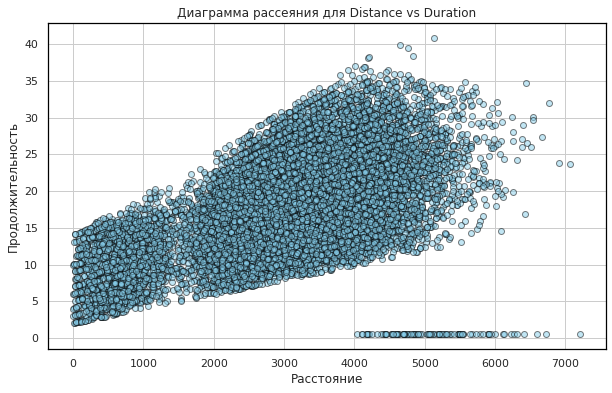

In [29]:
plt.figure(figsize=(10, 6))
plt.scatter(rides['distance'], rides['duration'], color='skyblue', edgecolor='black',  alpha=0.5)
plt.title('Диаграмма рассеяния для Distance vs Duration')
plt.xlabel('Расстояние')
plt.ylabel('Продолжительность')
plt.grid(True)
plt.show()

In [30]:
display(rides[rides['duration'] < 1].sort_values(by='duration'))


,user_id,distance,duration,date,month
6531,701,"4,196.4",0.5,2021-08-31,8
14615,1287,"5,944.8",0.5,2021-12-09,12
14574,1285,"6,316.6",0.5,2021-09-25,9
14417,1273,"4,178.9",0.5,2021-04-30,4
14342,1268,"4,177.1",0.5,2021-06-09,6
...,...,...,...,...,...
9581,928,"4,857.4",0.5,2021-06-06,6
9497,922,"4,620.9",0.5,2021-01-05,1
9282,907,"4,520.1",0.5,2021-04-24,4
10426,987,"5,375.1",0.5,2021-03-16,3


95 поездок имеют расстояние но время езды у них у всех 0.5, скорее всего технический сбой, будем считать это пропусками по времени. 


##### Check

Выведем весь список людей у кого поездка <1

In [31]:
with pd.option_context('display.max_rows', None):
    display((df.loc[df['duration'] < 1]).sort_values(by='date'))

,user_id,name,age,city,subscription_type,distance,duration,date,month
9497,922,Милена,21,Екатеринбург,free,"4,620.9",0.5,2021-01-05,1
12028,1104,Ольга,24,Краснодар,free,"4,807.1",0.5,2021-01-06,1
12088,1109,Демид,25,Ростов-на-Дону,free,"5,202.6",0.5,2021-01-08,1
8329,836,Всеволод,21,Тюмень,free,"4,958.9",0.5,2021-01-12,1
17242,1477,Ян,17,Сочи,free,"6,724.9",0.5,2021-01-12,1
13698,1224,Александр,25,Пятигорск,free,"4,430.5",0.5,2021-01-15,1
15492,1355,Владислава,29,Ростов-на-Дону,free,"5,913.0",0.5,2021-01-16,1
17004,1460,Жанна,27,Пятигорск,free,"5,531.3",0.5,2021-01-19,1
12642,1150,Рамиль,19,Омск,free,"5,666.7",0.5,2021-01-22,1
9268,906,Есения,32,Сочи,free,"5,258.2",0.5,2021-02-02,2


для всех пользователей посчитаем колличество поездок у каждого пользователя у которого есть хотя бы одна поездка 0.5 минут

In [32]:
user_ids = df.loc[df['duration'] < 1, 'user_id'].unique()

trip_counts = []

for user_id in user_ids:
    trip_counts.append(df.loc[df['user_id'] == user_id].shape[0])

min_trip_count = np.min(trip_counts)
avg_trip_count = np.mean(trip_counts)
max_trip_count = np.max(trip_counts)

print(f"Минимальное количество поездок: {min_trip_count}")
print(f"Среднее количество поездок: {avg_trip_count}")
print(f"Максимальное количество поездок: {max_trip_count}")

Минимальное количество поездок: 8
Среднее количество поездок: 14.522222222222222
Максимальное количество поездок: 22


проверим несколько человек "первая" ли это поездка

In [33]:
display(df[df['user_id'] == 701].sort_values(by='date'))

,user_id,name,age,city,subscription_type,distance,duration,date,month
6518,701,Иван,31,Екатеринбург,free,"2,676.5",17.5,2021-01-23,1
6519,701,Иван,31,Екатеринбург,free,"2,743.7",15.0,2021-02-13,2
6520,701,Иван,31,Екатеринбург,free,"2,893.7",11.9,2021-02-20,2
6521,701,Иван,31,Екатеринбург,free,"2,802.0",16.0,2021-03-12,3
6522,701,Иван,31,Екатеринбург,free,"3,509.0",13.1,2021-04-17,4
6523,701,Иван,31,Екатеринбург,free,"2,465.9",14.3,2021-05-31,5
6524,701,Иван,31,Екатеринбург,free,731.4,6.7,2021-06-02,6
6525,701,Иван,31,Екатеринбург,free,"3,903.2",18.4,2021-06-20,6
6526,701,Иван,31,Екатеринбург,free,"3,441.6",19.0,2021-07-04,7
6527,701,Иван,31,Екатеринбург,free,"1,133.6",6.3,2021-07-17,7


In [34]:
display(df[df['user_id'] == 1003].sort_values(by='date'))

,user_id,name,age,city,subscription_type,distance,duration,date,month
10644,1003,Екатерина,22,Сочи,free,"2,538.6",16.6,2021-01-02,1
10645,1003,Екатерина,22,Сочи,free,"4,175.5",27.8,2021-02-11,2
10646,1003,Екатерина,22,Сочи,free,"2,923.2",13.0,2021-02-24,2
10647,1003,Екатерина,22,Сочи,free,"3,391.3",10.8,2021-03-31,3
10648,1003,Екатерина,22,Сочи,free,"4,537.3",17.0,2021-05-11,5
10649,1003,Екатерина,22,Сочи,free,440.5,9.7,2021-05-13,5
10650,1003,Екатерина,22,Сочи,free,"4,204.3",0.5,2021-05-17,5
10651,1003,Екатерина,22,Сочи,free,"2,436.3",9.9,2021-06-24,6
10652,1003,Екатерина,22,Сочи,free,"3,914.3",18.2,2021-07-29,7
10653,1003,Екатерина,22,Сочи,free,"2,748.8",15.7,2021-08-10,8


In [35]:
df.loc[df['duration'] < 1, 'duration'] = None
display(df[df['duration'].isnull()])

,user_id,name,age,city,subscription_type,distance,duration,date,month
6531,701,Иван,31,Екатеринбург,free,"4,196.4",NaN,2021-08-31,8
6570,704,Мирон,29,Ростов-на-Дону,free,"4,830.8",NaN,2021-10-14,10
6680,712,Дарья,28,Москва,free,"4,684.0",NaN,2021-03-04,3
6695,713,Святослав,30,Краснодар,free,"5,215.6",NaN,2021-02-25,2
6768,718,Владислава,31,Москва,free,"5,197.4",NaN,2021-02-11,2
...,...,...,...,...,...,...,...,...,...
17004,1460,Жанна,27,Пятигорск,free,"5,531.3",NaN,2021-01-19,1
17242,1477,Ян,17,Сочи,free,"6,724.9",NaN,2021-01-12,1
17314,1483,Роберт,26,Екатеринбург,free,"4,445.5",NaN,2021-03-06,3
17505,1496,Яна,19,Москва,free,"5,722.6",NaN,2021-02-14,2


создадим коэфциент средней скорости для каждого user_id 

In [36]:
rides.loc[rides['duration'] < 1, 'duration'] = None
rides['ratio'] = rides['distance'] / rides['duration']
grouped_ratios = rides.groupby('user_id')['ratio'].mean().reset_index()
display(rides)

,user_id,distance,duration,date,month,ratio
0,1,"4,409.9",25.6,2021-01-01,1,172.3
1,1,"2,617.6",15.8,2021-01-18,1,165.5
2,1,754.2,6.2,2021-04-20,4,121.0
3,1,"2,694.8",18.5,2021-08-11,8,145.6
4,1,"4,028.7",26.3,2021-08-28,8,153.4
...,...,...,...,...,...,...
18063,1534,"3,781.1",19.8,2021-11-04,11,190.7
18064,1534,"2,840.4",21.4,2021-11-16,11,132.7
18065,1534,"3,826.2",18.4,2021-11-18,11,207.5
18066,1534,"2,902.3",16.7,2021-11-27,11,174.1


заполним пропуски новым временем.

In [37]:
df['duration'].fillna(df['distance'] / df['user_id'].map(grouped_ratios.set_index('user_id')['ratio']), inplace=True)

In [38]:
display(df[df['duration'].isnull()])

,user_id,name,age,city,subscription_type,distance,duration,date,month


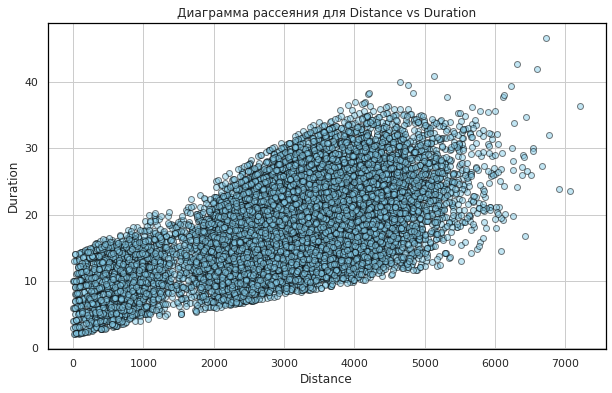

In [39]:
plt.figure(figsize=(10, 6))
plt.scatter(df['distance'], df['duration'], color='skyblue', edgecolor='black',  alpha=0.5)
plt.title('Диаграмма рассеяния для Distance vs Duration')
plt.xlabel('Distance')
plt.ylabel('Duration')
plt.grid(True)
plt.show()

### Вывод 


<ul>
    <li>Мы провели оптимизацию типов данных, чтобы уменьшить использование памяти.</li>
	<li>В данных не обнаружено пропущенных значений.</li>
	<li>обнаружено и удаленно 31 явных дубикатов в Таблице &quot;пользователи&quot;&nbsp;</li>
	<li>в таблице &quot;поездки&quot;&nbsp;дубликатов не обнаруженно</li>
	<li>95 поездок имели&nbsp;расстояние больше 4 км, но время езды у них у всех 0.5, посчитали это пропусками, заполнили данные используя коэфциент средней скорости по каждому пользователю</li>
</ul>

<p>&nbsp;</p>


## Шаг 3. Исследовательский анализ данных

Опишите и визуализируйте общую информацию о пользователях и поездках:

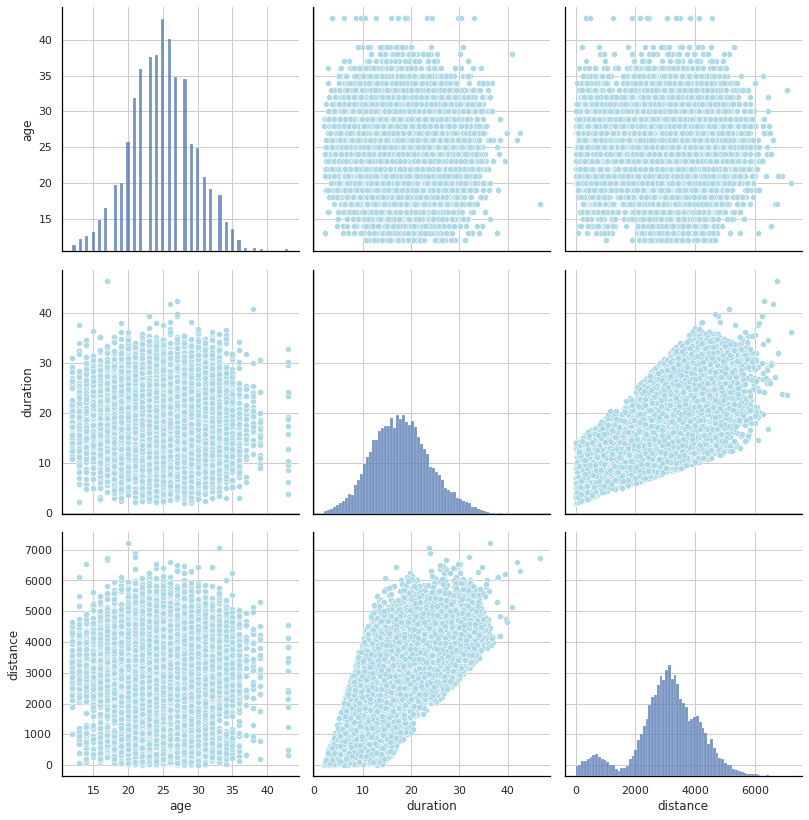

In [103]:
sns.pairplot(df[['age', 'duration', 'distance']])
plt.gcf().set_size_inches(12,12);


### Частота встречаемости городов;

In [41]:
count_users_city = users['city'].value_counts()
count_users_city

Пятигорск         219
Екатеринбург      204
Ростов-на-Дону    198
Краснодар         193
Сочи              189
Омск              183
Тюмень            180
Москва            168
Name: city, dtype: int64

География представленна 8 городами. Распределение примерно равными частями (от 11% до 14%) 

Больше всего в Пятигорске, меньше всего в Москва

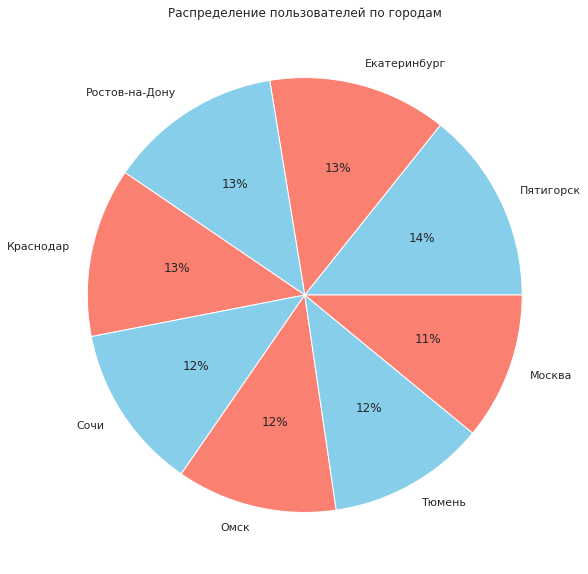

In [42]:
count_users_city.plot(
    figsize=(10, 10), 
    kind = 'pie',
    y = count_users_city,
    ylabel='',
    autopct = '%1.0f%%',
    title = 'Распределение пользователей по городам');

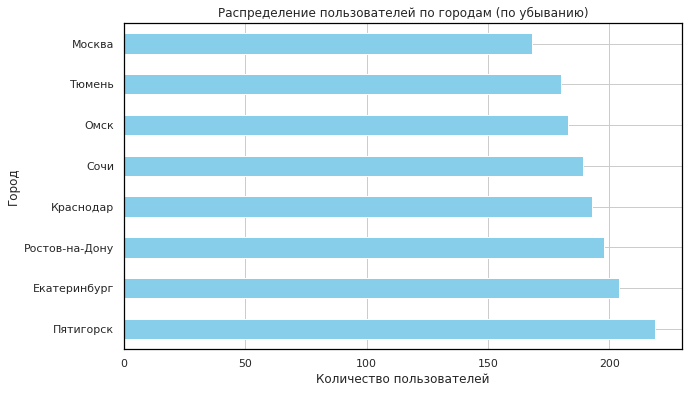

In [43]:
count_users_city.sort_values(ascending=False).plot(
    figsize=(10, 6),
    kind='barh',
    title='Распределение пользователей по городам (по убыванию)',
)
plt.xlabel('Количество пользователей')
plt.ylabel('Город')
plt.show()

### Cоотношение пользователей с подпиской и без подписки

In [44]:
count_subscription_type = users['subscription_type'].value_counts()
count_subscription_type

free     835
ultra    699
Name: subscription_type, dtype: int64

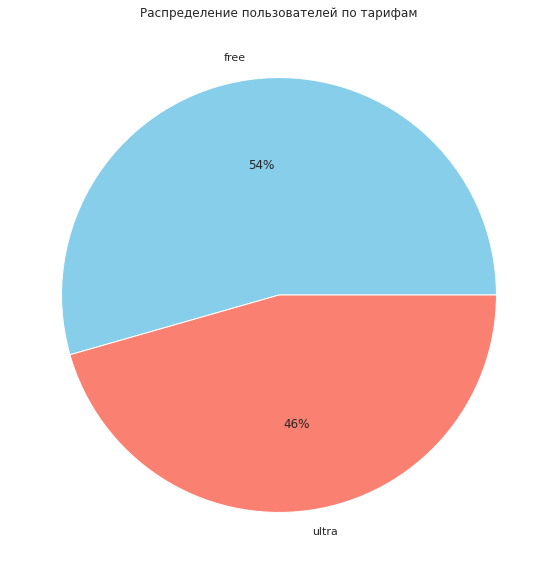

In [45]:
users['subscription_type'].value_counts().plot(
    figsize=(10,10), 
    kind = 'pie',
    y = count_subscription_type,
    ylabel='',
    autopct = '%1.0f%%',
    title = 'Распределение пользователей по тарифам');

Распределение пользователей по тарифам:
free - 54%, 
ultra - 46%

<div class="alert alert-block alert-success">
<b>✅Комментарий ревьюера:</b> А вот здесь круговая диаграмма очень кстати </div>

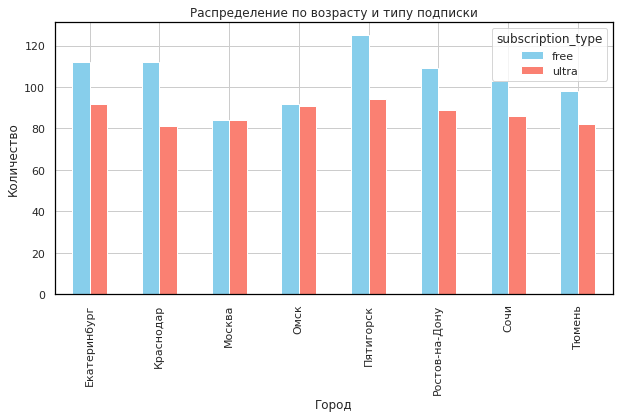

In [46]:
pivot_table_sub_city = users.pivot_table(index='city', columns='subscription_type', aggfunc='size', fill_value=0)
pivot_table_sub_city.plot(kind='bar', figsize=(10, 5))
plt.xlabel('Город')
plt.ylabel('Количество')
plt.title('Распределение по возрасту и типу подписки')
plt.show()

По всем городам преобладает бесплатная подписка. Только в Москве одинаковое соотношение

### Возраст пользователей

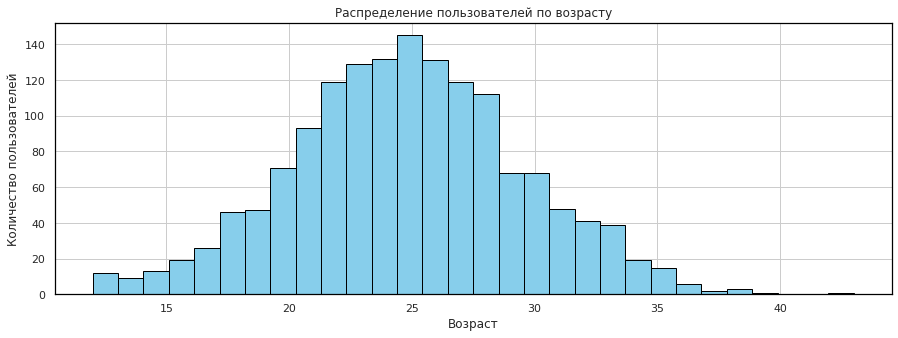

In [47]:
users.age.hist(bins = 30, figsize = (15,5), range = (12,43), color='skyblue', edgecolor='black');
plt.xlabel('Возраст')
plt.ylabel('Количество пользователей')
plt.title('Распределение пользователей по возрасту')
plt.show()

In [48]:
users.drop(columns=['user_id']).describe().T

,count,mean,std,min,25%,50%,75%,max
age,"1,534.0",24.9,4.6,12.0,22.0,25.0,28.0,43.0


Средний возвраст пользователей 25лет. Минимальный возвраст 12 лет максимальный 43.

!Правила большинства прокатов разрешают регаться только 18+

In [49]:
filtered_age = users[users['age'] < 18]
count = filtered_age.shape[0]
print("Количество строк, где возраст меньше 18:", count)


Количество строк, где возраст меньше 18: 79


In [50]:
age_before_18 = filtered_age.groupby(['age']).size()
display(age_before_18)


age
12     4
13     8
14     9
15    13
16    19
17    26
dtype: int64

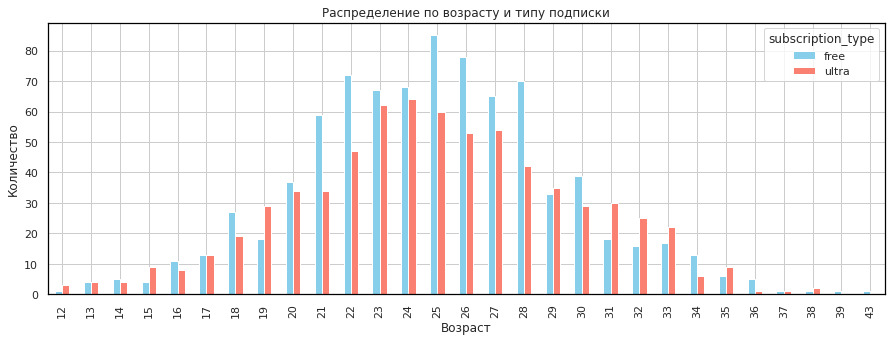

In [51]:
pivot_table_sub_age = users.pivot_table(index='age', columns='subscription_type', aggfunc='size', fill_value=0)
pivot_table_sub_age.plot(kind='bar', figsize=(15, 5))
plt.xlabel('Возраст')
plt.ylabel('Количество')
plt.title('Распределение по возрасту и типу подписки')
plt.show()

Платную подписку предпочетают больше люди в возврасте 19, 29, 31, 32, 33, 35 лет

###  Расстояние, которое пользователь преодолел за одну поездку

In [52]:
rides.drop(columns=['user_id', 'month', 'ratio']).describe().T

,count,mean,std,min,25%,50%,75%,max
distance,"18,068.0","3,070.7","1,116.8",0.9,"2,543.2","3,133.6","3,776.2","7,211.0"
duration,"17,973.0",17.9,6.0,2.0,13.7,17.7,21.7,40.8


In [53]:
(
    rides[['distance', 'duration']]
    .quantile([0.0012, 0.01, .2, 0.8, .99, .9988]) 
    .style.format("{:,.2f}")
)

,distance,duration
0.0012,36.38,2.83
0.01,208.08,4.96
0.2,"2,375.49",12.76
0.8,"3,975.36",22.82
0.99,"5,478.62",32.51
0.9988,"6,251.50",35.45


Среднее расстояние 3км, максимальное 7.2км

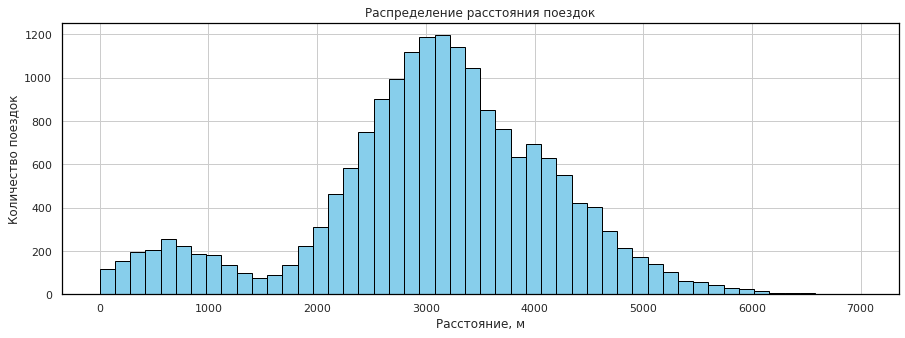

In [54]:
rides.distance.hist(bins=50, figsize=(15, 5), range=(0, 7000), color='skyblue', edgecolor='black')
plt.xlabel('Расстояние, м')
plt.ylabel('Количество поездок')
plt.title('Распределение расстояния поездок')
plt.show()

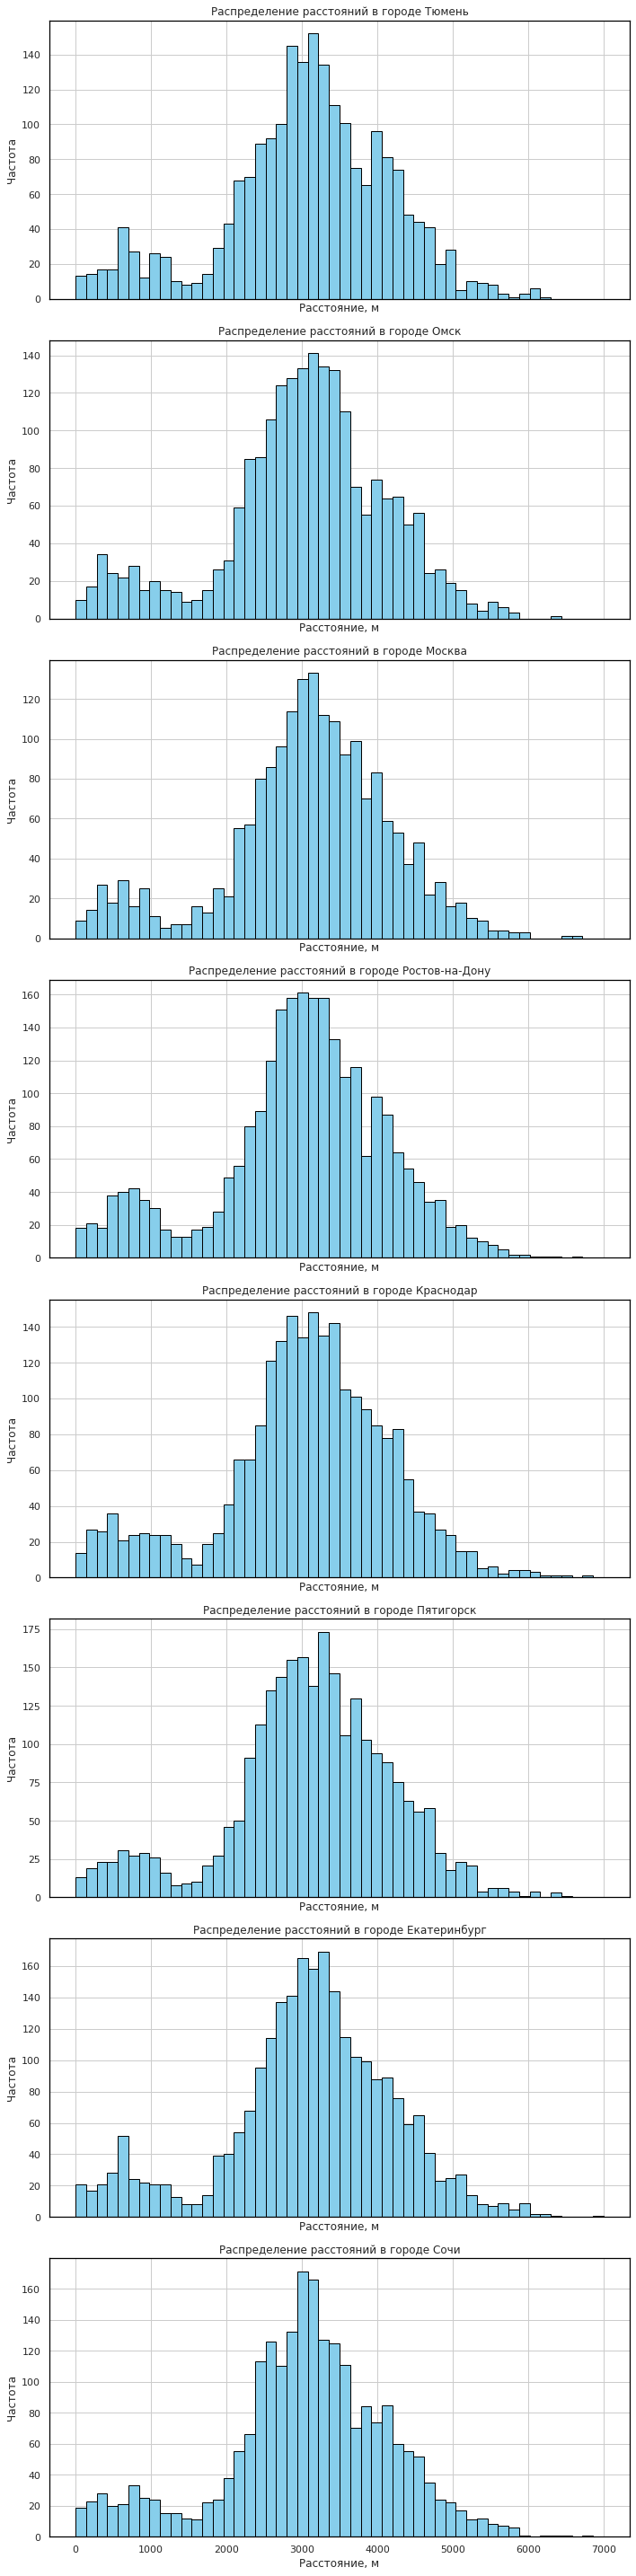

In [55]:
cities = df['city'].unique()

fig, axes = plt.subplots(len(cities), 1, figsize=(10, 5*len(cities)), sharex=True)

for i, city in enumerate(cities):
    
    city_data = df[df['city'] == city]['distance']
    axes[i].hist(city_data, bins=50, range=(0, 7000), color='skyblue', edgecolor='black')
    axes[i].set_title(f'Распределение расстояний в городе {city}')
    axes[i].set_xlabel('Расстояние, м')
    axes[i].set_ylabel('Частота')

plt.tight_layout()
plt.show()

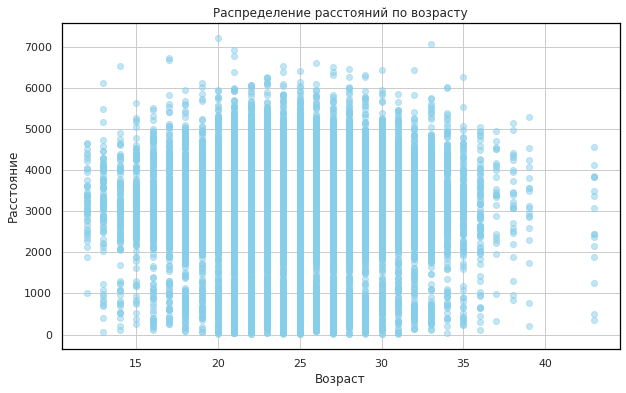

In [56]:
plt.figure(figsize=(10, 6))

plt.scatter(df['age'], df['distance'], color='skyblue', alpha=0.5)
plt.xlabel('Возраст')
plt.ylabel('Расстояние')
plt.title('Распределение расстояний по возрасту')

# Отображение графика
plt.grid(True)
plt.show()

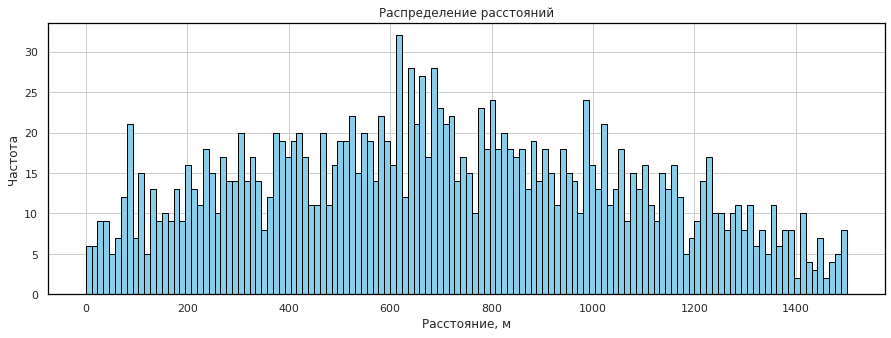

In [57]:
rides.distance.hist(bins = 130, figsize = (15,5), range = (0, 1500), color='skyblue', edgecolor='black');
plt.xlabel('Расстояние, м')
plt.ylabel('Частота')
plt.title('Распределение расстояний')
plt.show()

Среднее расстояние 3км, максимальное 7.2км

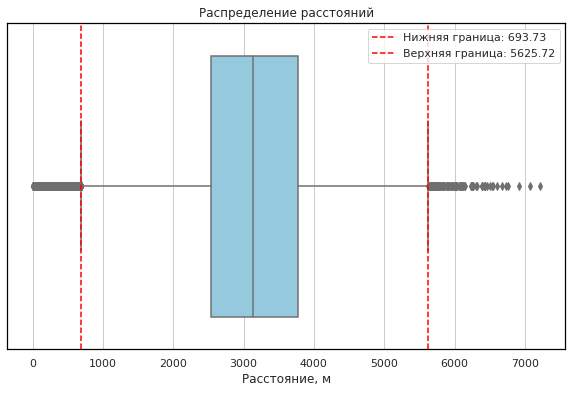

In [58]:
plt.figure(figsize=(10, 6))
sns.boxplot(x=rides['distance'], color='skyblue')
Q1 = rides['distance'].quantile(0.25)
Q3 = rides['distance'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
plt.axvline(x=lower_bound, color='red', linestyle='--', label=f'Нижняя граница: {lower_bound:.2f}')
plt.axvline(x=upper_bound, color='red', linestyle='--', label=f'Верхняя граница: {upper_bound:.2f}')
plt.legend()
plt.xlabel('Расстояние, м')
plt.title('Распределение расстояний')
plt.show()

### Продолжительность поездок

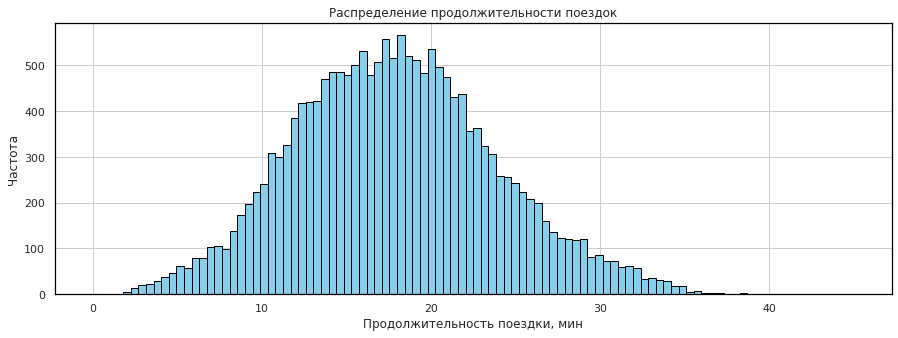

In [59]:
rides.duration.hist(bins = 100, figsize = (15,5), range = (0,45), color='skyblue', edgecolor='black');
plt.xlabel('Продолжительность поездки, мин')
plt.ylabel('Частота')
plt.title('Распределение продолжительности поездок')

plt.show()

Среднее время 18 минут, максимальное 46.6минут

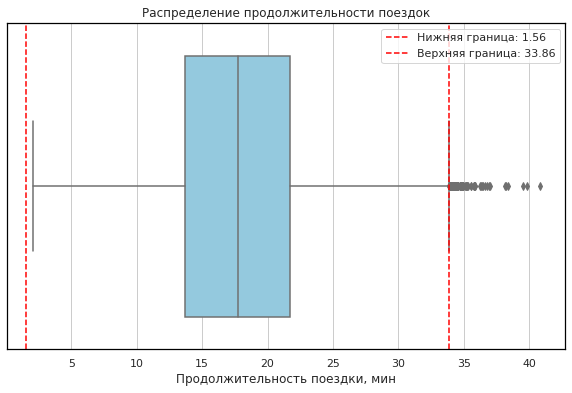

In [60]:
plt.figure(figsize=(10, 6))
sns.boxplot(x=rides['duration'], color='skyblue')
Q1 = rides['duration'].quantile(0.25)
Q3 = rides['duration'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
plt.axvline(x=lower_bound, color='red', linestyle='--', label=f'Нижняя граница: {lower_bound:.2f}')
plt.axvline(x=upper_bound, color='red', linestyle='--', label=f'Верхняя граница: {upper_bound:.2f}')
plt.legend()
plt.xlabel('Продолжительность поездки, мин')
plt.title('Распределение продолжительности поездок')
plt.show()
plt.show()

In [61]:
riders_count = rides['user_id'].value_counts().sort_values(ascending=False)
total_distance_by_user = rides.groupby(['user_id']).sum()
merged_data = riders_count.to_frame(name='rides_count').merge(total_distance_by_user, left_index=True, right_index=True)
display(merged_data.head())
display(merged_data.tail())

,rides_count,distance,duration,month,ratio
1236,27,"78,745.0",446.2,167,"5,148.6"
1063,26,"79,325.8",440.5,173,"5,224.8"
783,26,"68,009.9",435.2,151,"4,012.3"
1204,24,"72,873.8",432.2,152,"4,007.0"
1149,23,"67,160.3",431.5,172,"3,458.4"


,rides_count,distance,duration,month,ratio
354,3,"10,250.4",77.0,18,426.0
73,3,"6,504.2",34.2,12,542.9
633,3,"10,348.4",51.7,11,645.6
342,2,"5,530.3",44.8,9,244.0
366,2,"5,677.2",36.4,9,312.5


### Вывод

<p><strong>География и распределение пользователей</strong>:</p>

<ul>
	<li>География представлена восьмью городами, с распределением примерно равными частями.</li>
	<li>Наибольшее количество пользователей зарегистрировано в Пятигорске(226), а наименьшее - в Москве(172).</li>
</ul>

<p><strong>Распределение по тарифам и возрастной состав пользователей</strong>:</p>

<ul>
	<li>Пользователи распределены примерно поровну между тарифами &quot;free&quot; (54%) и &quot;ultra&quot; (46%).</li>
    <li>По всем городам преобладает бесплатная подписка. Только в Москве одинаковое соотношение</li>
	<li>Основной возраст пользователей находится в диапазоне от 20 до 30 лет.</li>
	<li>Средний возраст пользователей составляет 25 лет, с минимальным значением в 12 лет и максимальным в 43 года.</li>
	<li>Обнаружено 79 пользователей младше 18 лет, что не соответствует правилам большинства прокатов, требующих регистрацию только лиц старше 18 лет.</li>
    <li>Платную подписку предпочетают больше люди в возврасте 19, 29, 31, 32, 33, 35 лет</li>
</ul>
<p><strong>Характеристики поездок</strong>:</p>

<ul>
	<li>Основное расстояние поездки составляет от 2 до 4.5 км, среднее расстояние - 3 км, максимальное - 7.2 км.</li>
	<li>Основное время поездки составляет от 10 до 27 минут, среднее время - 18 минут, максимальное - 46.6 минут.</li>
	<li>Самое большое количество поездок (27) было совершено одним пользователем на расстояние 78.7 км с общим временем в 446 минут.</li>
	<li>Меньше всего поездок (2) было у двух пользователей на расстояние 5.5 и 5.6 км с временем 44 и 36 минут соответственно.</li>
</ul>


## Шаг 4. Объединение данных

###  Объедините данные о пользователях, поездках и подписках в один датафрейм. Для этого воспользуйтесь методом

In [62]:
print(df.shape[0]) 

18068


In [63]:
all_df = df.merge(subs, on='subscription_type')

display(all_df.sample(10))

,user_id,name,age,city,subscription_type,distance,duration,date,month,minute_price,start_ride_price,subscription_fee
3497,376,Анна,28,Ростов-на-Дону,ultra,"2,656.7",18.9,2021-04-07,4,6,0,199
10650,1003,Екатерина,22,Сочи,free,"4,204.3",20.5,2021-05-17,5,8,50,0
3162,341,Василиса,23,Пятигорск,ultra,"3,128.3",12.7,2021-03-06,3,6,0,199
12338,1127,Рустам,18,Екатеринбург,free,"2,008.5",14.3,2021-04-22,4,8,50,0
17486,1493,Федор,24,Омск,free,"2,464.4",10.2,2021-12-28,12,8,50,0
16239,1405,Нелли,23,Пятигорск,free,"1,586.8",14.0,2021-09-22,9,8,50,0
6939,730,Анна,28,Омск,free,"4,133.8",22.9,2021-01-29,1,8,50,0
1768,192,Никита,25,Пятигорск,ultra,"4,120.8",25.5,2021-04-04,4,6,0,199
383,41,Данила,21,Екатеринбург,ultra,"3,392.7",13.7,2021-07-11,7,6,0,199
4732,510,Роман,24,Ростов-на-Дону,ultra,822.8,8.9,2021-03-12,3,6,0,199


In [64]:
print(all_df.shape[0]) 

18068


<div class="alert alert-block alert-warning">
<b>🔁Комментарий ревьюера:</b>

Тут стоит проверить количество строк полученной таблицы и сравнить ее с количеством строк таблиц до объединения, чтобы убедиться что мы ничего не потеряли и не добавили лишнего.

</div>

<div class="alert alert-block alert-success">
<b>✅Комментарий ревьюера 2:</b> Отлично, исправлено!👍  </div>

<div class="alert alert-block alert-info">
<b>🔄Комментарий студента:</b> 
проверил, все на месте
</div

###  Создайте ещё два датафрейма из датафрейма:
-c данными о пользователях без подписки;

-с данными о пользователях с подпиской.

In [65]:
free_sub = all_df.query("subscription_type == 'free'")
display(free_sub.head())

,user_id,name,age,city,subscription_type,distance,duration,date,month,minute_price,start_ride_price,subscription_fee
6500,700,Айдар,22,Омск,free,"2,515.7",14.9,2021-01-02,1,8,50,0
6501,700,Айдар,22,Омск,free,846.9,16.2,2021-02-01,2,8,50,0
6502,700,Айдар,22,Омск,free,"4,004.4",20.0,2021-02-04,2,8,50,0
6503,700,Айдар,22,Омск,free,"1,205.9",9.8,2021-02-10,2,8,50,0
6504,700,Айдар,22,Омск,free,"3,047.4",17.4,2021-02-14,2,8,50,0


In [66]:
ultra_sub = all_df.query("subscription_type == 'ultra'")
display(ultra_sub.head())

,user_id,name,age,city,subscription_type,distance,duration,date,month,minute_price,start_ride_price,subscription_fee
0,1,Кира,22,Тюмень,ultra,"4,409.9",25.6,2021-01-01,1,6,0,199
1,1,Кира,22,Тюмень,ultra,"2,617.6",15.8,2021-01-18,1,6,0,199
2,1,Кира,22,Тюмень,ultra,754.2,6.2,2021-04-20,4,6,0,199
3,1,Кира,22,Тюмень,ultra,"2,694.8",18.5,2021-08-11,8,6,0,199
4,1,Кира,22,Тюмень,ultra,"4,028.7",26.3,2021-08-28,8,6,0,199


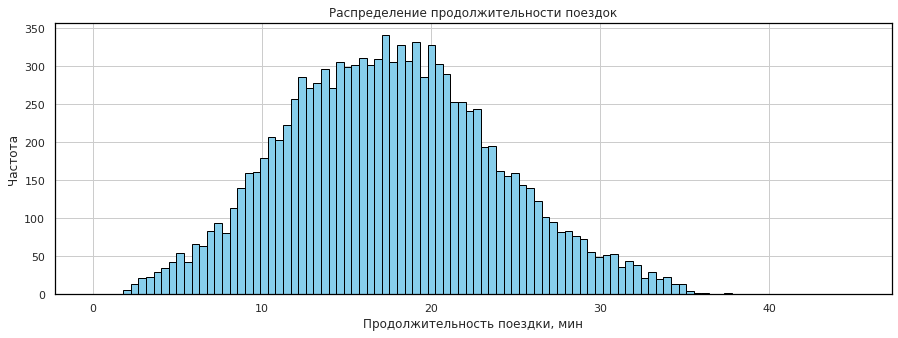

In [67]:
free_sub.duration.hist(bins = 100, figsize = (15,5), range = (0,45), color='skyblue', edgecolor='black');
plt.xlabel('Продолжительность поездки, мин')
plt.ylabel('Частота')
plt.title('Распределение продолжительности поездок')
plt.show()

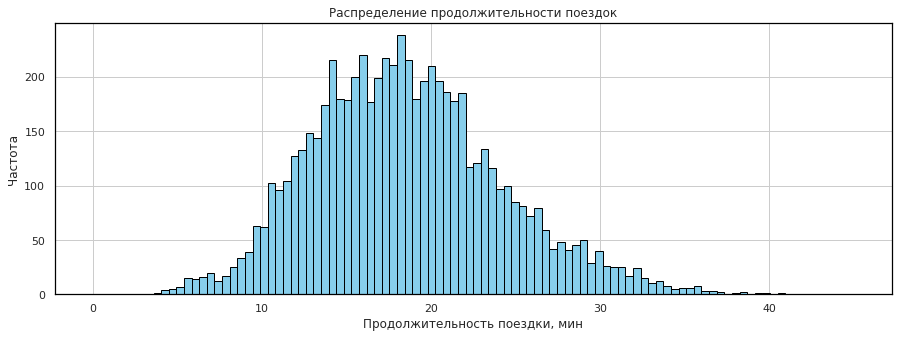

In [68]:
ultra_sub.duration.hist(bins = 100, figsize = (15,5), range = (0,45), color='skyblue', edgecolor='black');
plt.xlabel('Продолжительность поездки, мин')
plt.ylabel('Частота')
plt.title('Распределение продолжительности поездок')
plt.show()

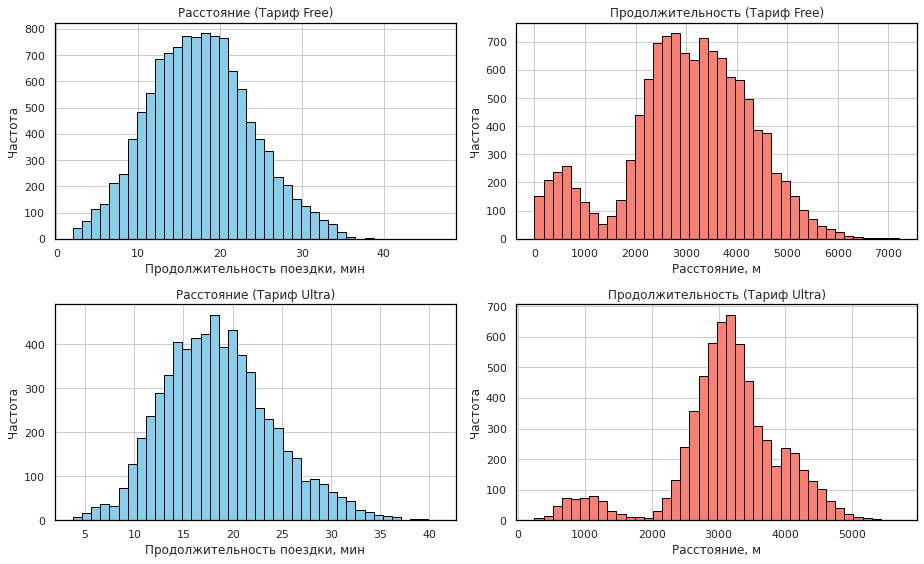

In [69]:
plt.figure(figsize=(13,8))

plt.subplot(2, 2, 1)
plt.hist(free_sub['duration'], bins=40, color='skyblue', edgecolor='black')
plt.title('Расстояние (Тариф Free)')
plt.xlabel('Продолжительность поездки, мин')
plt.ylabel('Частота')


plt.subplot(2, 2, 2)
plt.hist(free_sub['distance'], bins=40, color='salmon', edgecolor='black')
plt.title('Продолжительность (Тариф Free)')
plt.xlabel('Расстояние, м')
plt.ylabel('Частота')

plt.subplot(2, 2, 3)
plt.hist(ultra_sub['duration'], bins=40, color='skyblue', edgecolor='black')
plt.title('Расстояние (Тариф Ultra)')
plt.xlabel('Продолжительность поездки, мин')
plt.ylabel('Частота')


plt.subplot(2, 2, 4)
plt.hist(ultra_sub['distance'], bins=40, color='salmon', edgecolor='black')
plt.title('Продолжительность (Тариф Ultra)')
plt.xlabel('Расстояние, м')
plt.ylabel('Частота')

plt.tight_layout()
plt.show()

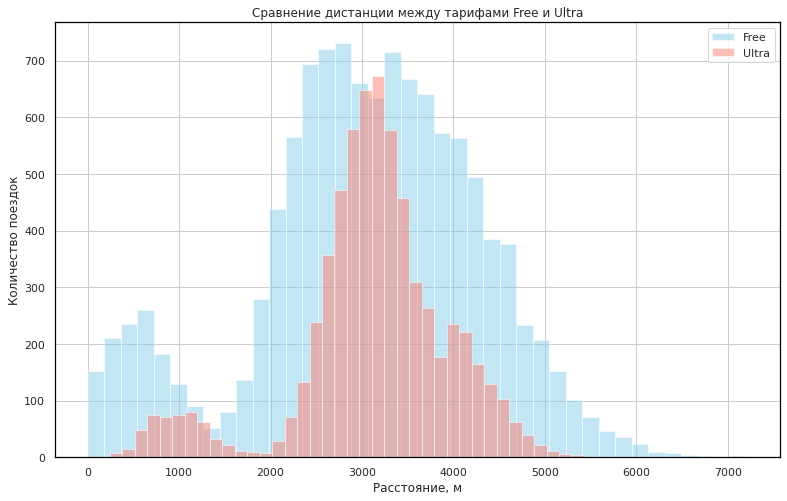

In [70]:
plt.figure(figsize=(13,8))
plt.hist(free_sub['distance'], bins=40, color='skyblue', alpha=0.5, label='Free')
plt.hist(ultra_sub['distance'], bins=40, color='salmon', alpha=0.5, label='Ultra')
plt.title('Сравнение дистанции между тарифами Free и Ultra')
plt.xlabel('Расстояние, м')
plt.ylabel('Количество поездок')
plt.legend()
plt.show()

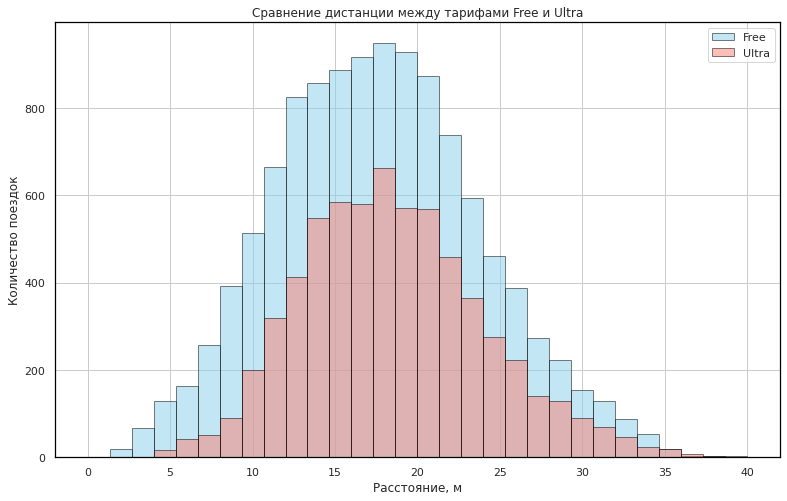

In [71]:
plt.figure(figsize=(13,8))
plt.hist(free_sub['duration'], bins=30, color='skyblue', alpha=0.5, range = (0,40), label='Free', edgecolor='black')
plt.hist(ultra_sub['duration'], bins=30, color='salmon', alpha=0.5, range = (0,40), label='Ultra', edgecolor='black')
plt.title('Сравнение дистанции между тарифами Free и Ultra')
plt.xlabel('Расстояние, м')
plt.ylabel('Количество поездок')
plt.legend()
plt.show()

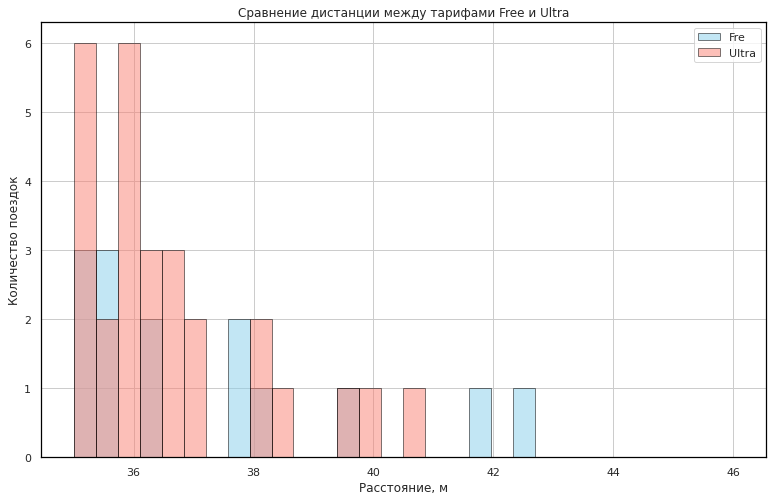

In [72]:
plt.figure(figsize=(13,8))
plt.hist(free_sub['duration'], bins=30, color='skyblue', alpha=0.5, range = (35,46), label='Fre', edgecolor='black')
plt.hist(ultra_sub['duration'], bins=30, color='salmon', alpha=0.5, range = (35,46), label='Ultra', edgecolor='black')
plt.title('Сравнение дистанции между тарифами Free и Ultra')
plt.xlabel('Расстояние, м')
plt.ylabel('Количество поездок')
plt.legend()
plt.show()

посмотрим % соотношение поездок по тарифам

In [73]:
subscription_percentage = all_df['subscription_type'].value_counts(normalize=True) * 100
print(subscription_percentage)


free    64.0
ultra   36.0
Name: subscription_type, dtype: float64


Для тарифа Ультра выведу значения "колличество, минимальное, максимальное, среднее и медианное" для расстояния и времени

In [74]:
(
        ultra_sub[['duration', 'distance']]
        .apply (['count', 'min', 'max', 'mean', 'median'])
        .T
        .style.format("{:,.2f}")
    )

,count,min,max,mean,median
duration,"6,500.00",3.76,40.82,18.54,18.18
distance,"6,500.00",244.21,"5,699.77","3,115.45","3,148.64"


Для тарифа Free выведу значения "колличество, минимальное, максимальное, среднее и медианное" для расстояния и времени

In [75]:
(
        free_sub[['duration', 'distance']]
        .apply (['count', 'min', 'max', 'mean', 'median'])
        .T
        .style.format("{:,.2f}")
    )

,count,min,max,mean,median
duration,"11,568.00",2.04,46.56,17.63,17.45
distance,"11,568.00",0.86,"7,211.01","3,045.50","3,114.65"


посмотрим % соотношение общего расстояния и времени для двух тарифов

In [76]:
total_distance_free = free_sub['distance'].sum()
total_duration_free = free_sub['duration'].sum()
total_distance_ultra = ultra_sub['distance'].sum()
total_duration_ultra = ultra_sub['duration'].sum()
total_distance_all = total_distance_free + total_distance_ultra
total_duration_all = total_duration_free + total_duration_ultra
percentage_distance_free = (total_distance_free / total_distance_all) * 100
percentage_duration_free = (total_duration_free / total_duration_all) * 100
percentage_distance_ultra = (total_distance_ultra / total_distance_all) * 100
percentage_duration_ultra = (total_duration_ultra / total_duration_all) * 100

In [77]:
data = {
    'Тариф': ['free_sub', 'ultra_sub', 'free_sub', 'ultra_sub'],
    'Параметр': ['distance', 'distance', 'duration', 'duration'],
    'Общее количество': [total_distance_free, total_distance_ultra, total_duration_free, total_duration_ultra],
    'Процентное соотношение': [percentage_distance_free, percentage_distance_ultra, percentage_duration_free, percentage_duration_ultra]
}

tarif_procentage = pd.DataFrame(data)
tarif_procentage['Процентное соотношение'] = tarif_procentage['Процентное соотношение'].map('{:.2f}%'.format)
display(tarif_procentage)

,Тариф,Параметр,Общее количество,Процентное соотношение
0,free_sub,distance,"35,230,288.0",63.50%
1,ultra_sub,distance,"20,250,396.0",36.50%
2,free_sub,duration,"203,928.9",62.85%
3,ultra_sub,duration,"120,522.9",37.15%


### Вывод

<p>После объединения данных о пользователях, их поездках и используемых тарифах в единый датафрейм - all_df, мы разделили информацию на два датафрейма: free_sub - с данными о пользователях с тарифом&nbsp; без подписки и ultra_sub - с данными о пользователях с подпиской.</p>

<ol>
	<li>Поездки на тарифе &#39;free&#39; составляют 64.0%, в то время как на тарифе &#39;ultra&#39; - 36.0%. Это означает, что количество поездок на тарифе &#39;free&#39; больше, чем на тарифе &#39;ultra&#39;.</li>
	<li>Количество пользователей, выбравших тариф &#39;free&#39;, составляет 54%, в то время как тариф &#39;ultra&#39; выбрали 46% пользователей. </li>
	<li>Следовательно,&nbsp; тариф &#39;free&#39; привлекает больше пользователей, их средняя активность в виде количества поездок на одного пользователя оказывается выше, чем у пользователей тарифа &#39;ultra&#39;. в 1.7 раз, не смотря на то что люди платят абонентскую плату, ездят меньше.</li>
	<li>Но на тарифе Free общее расстояние и время не значительно меньше, чем у людей на тарифе Ultra.</li>
	<li>Free&nbsp;минималные показатели 2.04 минуты, а расстояние&nbsp;0.86 метра, а максимальные 46.56 минут и&nbsp;7211 метров.&nbsp; В среднем 17.63 минут и 3,045&nbsp;метров</li>
	<li>Ultra&nbsp; минималные показатели 3.76 минуты, а расстояние&nbsp;244 метра, а максимальные 40 минут и&nbsp;5,699 метров.&nbsp; В среднем 18.54 минут и&nbsp;3,115 метров</li>
</ol>

<p>&nbsp;</p>

<p>Исходя из этой информации, можно сделать вывод, что пользователи с бесплатным тарифом могут совершают более длительные поездки и преодолевают большее расстояние по сравнению с пользователями, выбравшими платный тариф. Хотя средние показатели отличаются в 1 минуту и 100 метров. У тарифа Ultra концентрация долгих поездок не значительно больше</p>

<p>&nbsp;</p>


## Шаг 5. Подсчёт выручки

проверим есть ли люди с двумя подписками.

In [78]:
user_sub_counts = all_df.groupby('user_id')['subscription_type'].nunique()
users_with_both_subs = user_sub_counts[user_sub_counts == 2]
print("Пользователи с двумя подписками ultra и free:")
print(users_with_both_subs)

Пользователи с двумя подписками ultra и free:
Series([], Name: subscription_type, dtype: int64)


In [79]:
all_df.head(10)

,user_id,name,age,city,subscription_type,distance,duration,date,month,minute_price,start_ride_price,subscription_fee
0,1,Кира,22,Тюмень,ultra,"4,409.9",25.6,2021-01-01,1,6,0,199
1,1,Кира,22,Тюмень,ultra,"2,617.6",15.8,2021-01-18,1,6,0,199
2,1,Кира,22,Тюмень,ultra,754.2,6.2,2021-04-20,4,6,0,199
3,1,Кира,22,Тюмень,ultra,"2,694.8",18.5,2021-08-11,8,6,0,199
4,1,Кира,22,Тюмень,ultra,"4,028.7",26.3,2021-08-28,8,6,0,199
5,1,Кира,22,Тюмень,ultra,"2,770.9",16.7,2021-10-09,10,6,0,199
6,1,Кира,22,Тюмень,ultra,"3,039.0",14.9,2021-10-19,10,6,0,199
7,1,Кира,22,Тюмень,ultra,"2,842.1",23.1,2021-11-06,11,6,0,199
8,1,Кира,22,Тюмень,ultra,"3,412.7",15.2,2021-11-14,11,6,0,199
9,1,Кира,22,Тюмень,ultra,748.7,15.0,2021-11-22,11,6,0,199


In [80]:
all_df['duration'] = np.ceil(all_df['duration']) 

In [81]:
revenue_calc = pd.pivot_table(all_df, index=['month', 'user_id'],
                           values = ['name', 'subscription_type', 'distance', 'duration'], 
                                     aggfunc = {
                                         'name' : len, 
                                         'subscription_type': 'first', 
                                         'distance': sum, 
                                         'duration' : sum
                                     })

revenue_calc.rename(columns = {'name' : 'trip counter'}, inplace = True)


In [82]:
display(revenue_calc)

distance  duration  trip counter subscription_type
month user_id                                                    
1     1         7,027.5      42.0             2             ultra
      3         3,061.8      13.0             1             ultra
      5         3,914.6      13.0             1             ultra
      7         6,478.1      28.0             2             ultra
      12        3,577.2      33.0             1             ultra
...                 ...       ...           ...               ...
12    1525      4,597.9      34.0             1              free
      1526      3,644.1      23.0             1              free
      1528      3,998.6      11.0             1              free
      1532      6,111.9      42.0             2              free
      1534      2,371.7      16.0             1              free

[11331 rows x 4 columns]

In [83]:
revenue_calc.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 11331 entries, (1, 1) to (12, 1534)
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   distance           11331 non-null  float32
 1   duration           11331 non-null  float32
 2   trip counter       11331 non-null  int64  
 3   subscription_type  11331 non-null  object 
dtypes: float32(2), int64(1), object(1)
memory usage: 311.0+ KB


In [84]:
print(mem_usage(revenue_calc))
convert_category =['subscription_type']
revenue_calc[convert_category] = revenue_calc[convert_category].astype('category')
convert_int16 = ['duration', 'trip counter']
revenue_calc[convert_int16] = revenue_calc[convert_int16].astype('int16') 
print(mem_usage(revenue_calc))


0.88 MB
0.14 MB


In [87]:
free_revenue = 8 * revenue_calc['duration'] + 50 * revenue_calc['trip counter']
ultra_revenue = 6 * revenue_calc['duration'] + 199
revenue_calc['revenue_month'] = np.where(revenue_calc['subscription_type'] == 'free', free_revenue, ultra_revenue)

In [88]:
# код ревьюера
agg_tbl = all_df.groupby(['user_id', 'month']).agg({'subscription_type' : 'first'
                                        , 'duration' : 'sum'
                                        , 'distance' : 'sum'
                                        , 'date' : 'count'
                                       }
                                      ).reset_index() # формируем сводную таблицу

rev_table = agg_tbl.merge(subs, on='subscription_type') # добавляем данные о тарифах

rev_table['revenue'] = (rev_table['duration'] * rev_table['minute_price'] 
                     + rev_table['start_ride_price'] * rev_table['date'] # считаем выручку
                     + rev_table['subscription_fee']
                       )

display(rev_table.head())

,user_id,month,subscription_type,duration,distance,date,minute_price,start_ride_price,subscription_fee,revenue
0,1,1,ultra,42.0,"7,027.5",2,6,0,199,451.0
1,1,4,ultra,7.0,754.2,1,6,0,199,241.0
2,1,8,ultra,46.0,"6,723.5",2,6,0,199,475.0
3,1,10,ultra,32.0,"5,809.9",2,6,0,199,391.0
4,1,11,ultra,56.0,"7,003.5",3,6,0,199,535.0


In [89]:
display(revenue_calc)


distance  duration  trip counter subscription_type  \
month user_id                                                       
1     1         7,027.5        42             2             ultra   
      3         3,061.8        13             1             ultra   
      5         3,914.6        13             1             ultra   
      7         6,478.1        28             2             ultra   
      12        3,577.2        33             1             ultra   
...                 ...       ...           ...               ...   
12    1525      4,597.9        34             1              free   
      1526      3,644.1        23             1              free   
      1528      3,998.6        11             1              free   
      1532      6,111.9        42             2              free   
      1534      2,371.7        16             1              free   

               revenue_month  
month user_id                 
1     1                  451  
      3                  277  
      5                  277  
      7                  367  
      12                 397  
...                      ...  
12    1525               322  
      1526               234  
      1528               138  
      1532               436  
      1534               178  

[11331 rows x 5 columns]

### Вывод


<p>Создали датафрейм&nbsp; <b>revenue_calc</b> с агрегированными данными о поездках на основе датафрейма с объединёнными данными.</p>

<p>Нашли суммарное расстояние, количество поездок и суммарное время для каждого пользователя за каждый месяц.</p>

<p>В этот же датафрейм добавили столбец с помесячной выручкой, которую принёс каждый пользователь. Для этого обратитились к информации об условиях оплаты для подписчиков и тех, у кого нет подписки. Продолжительность каждой поездки в каждой строке исходного датафрейма для подсчёта стоимости округлили до следующего целого числа.</p>


## Шаг 6. Проверка гипотез

Продакт-менеджеры сервиса хотят увеличить количество пользователей с подпиской. Для этого они будут проводить различные акции, но сначала нужно выяснить несколько важных моментов.

###  Задание 6.1

 Важно понять, тратят ли пользователи с подпиской больше времени на поездки? Если да, то пользователи с подпиской могут быть «выгоднее» для компании. Проверьте гипотезу. Используйте исходные данные о продолжительности каждой сессии — отдельно для подписчиков и тех, у кого нет подписки.

<p><strong>Проверим гипотезу:&nbsp;пользователи с тарифом Ultra тратят больше времени на поездки, чем пользователи тарифа Free</strong></p>

H0: Время пользователей на подписке ultra = время пользователей на подписке free

H1: Время пользователей на подписке ultra > время пользователей на подписке free

alpha = 0.05

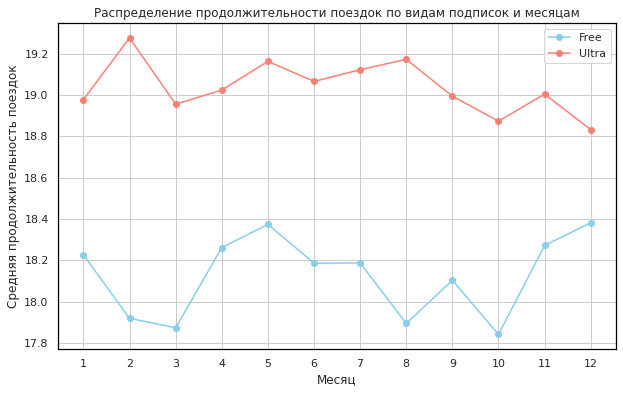

In [91]:
avg_duration_by_subscription_month = all_df.groupby(['subscription_type', 'month'])['duration'].mean()
free_duration = avg_duration_by_subscription_month['free']
ultra_duration = avg_duration_by_subscription_month['ultra']

plt.figure(figsize=(10, 6))
plt.plot(free_duration.index, free_duration.values, label='Free', marker='o')
plt.plot(ultra_duration.index, ultra_duration.values, label='Ultra', marker='o')
plt.title('Распределение продолжительности поездок по видам подписок и месяцам')
plt.xlabel('Месяц')
plt.ylabel('Средняя продолжительность поездок')
plt.legend()
plt.grid(True)
plt.xticks(range(1, 13))
plt.show()

#### Вывод


Поскольку p-value значительно меньше уровня значимости (alpha = 0.05), мы отвергаем нулевую гипотезу. Это означает, что у нас есть статистически значимые доказательства в пользу того, что время пользователей с тарифом Ultra на поездки в среднем больше, чем время пользователей с тарифом Free.

### Задание 6.2

Расстояние одной поездки в 3130 метров — оптимальное с точки зрения износа самоката. Можно ли сказать, что среднее расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает 3130 метров? Проверьте гипотезу и сделайте выводы.

<p><strong>Проверим гипотезу:&nbsp;пользователи с тарифом Ultra в среднем за одноу поездку проезжают меньше 3130 метров </strong></p>

H0: Среднее расстояние пользователей на подписке ultra за одну поездку = 3130

H1: Среднее расстояние пользователей на подписке ultra за одну поездку > 3130

alpha = 0.05

In [92]:
alpha = 0.05
popmean = 3130
distance_ultra = ultra_sub['distance']
t_statistic, p_value = stats.ttest_1samp(distance_ultra, popmean)

print("p-значение:", p_value)
if p_value < alpha:
    print("Отвергаем нулевую гипотезу: среднее расстояние за одну поездку  превышает", popmean)
else:
    print("Не отвергаем нулевую гипотезу: среднее расстояние за одну поездку не превышает", popmean)

p-значение: 0.16093106752941697
Не отвергаем нулевую гипотезу: среднее расстояние за одну поездку не превышает 3130


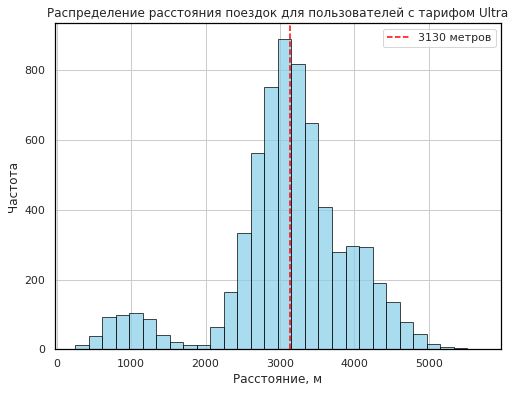

In [93]:
plt.figure(figsize=(8, 6))
plt.hist(distance_ultra, bins=30, color='skyblue', edgecolor='black', alpha=0.7)
plt.axvline(x=3130, color='red', linestyle='--', label='3130 метров')
plt.title('Распределение расстояния поездок для пользователей с тарифом Ultra')
plt.xlabel('Расстояние, м')
plt.ylabel('Частота')
plt.legend()
plt.grid(True)
plt.show()

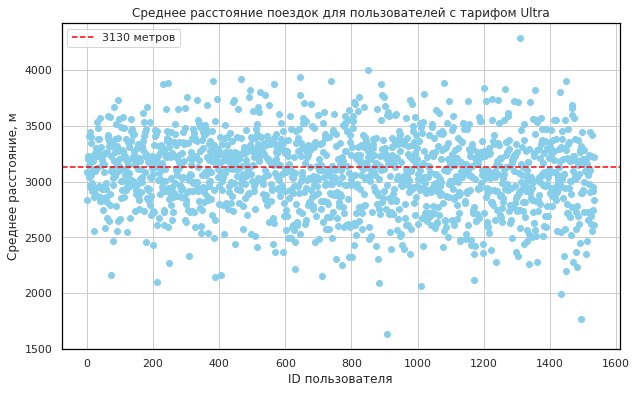

In [94]:
average_distance_per_user = all_df.groupby('user_id')['distance'].mean()
plt.figure(figsize=(10, 6))
plt.scatter(average_distance_per_user.index, average_distance_per_user.values, color='skyblue')
plt.axhline(y=3130, color='red', linestyle='--', label='3130 метров')
plt.title('Среднее расстояние поездок для пользователей с тарифом Ultra')
plt.xlabel('ID пользователя')
plt.ylabel('Среднее расстояние, м')
plt.legend()
plt.grid(True)
plt.show()

#### Вывод


так как p-value больше уровня значимости alpha (0.05), мы не можем отвергнуть нулевую гипотезу. Это означает, что у нас достаточно статистических доказательств, чтобы сделать вывод о том, что среднее расстояние за одну поездку на тарифе ультра не превышает 3130

In [95]:
mean_distance_by_subscription = ultra_sub.groupby('subscription_type')['distance'].mean()

print(mean_distance_by_subscription)

subscription_type
free        NaN
ultra   3,115.4
Name: distance, dtype: float32


### Задание 6.3

Проверьте гипотезу о том, будет ли помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки. Сделайте вывод.

<p><strong>Проверим гипотезу: выручка от пользователей Ultra&nbsp; в месяц выше, чем выручка от пользователей Free</strong></p>

H0: Выручка пользователей на подписке Ultra = выручка пользователей на подписке Free

H1: Выручка пользователей на подписке Ultra > выручка пользователей на подписке Free

alpha = 0.05

free_sub 

ultra_sub

In [96]:
revenue_ultra = revenue_calc[revenue_calc['subscription_type'] == 'ultra']['revenue_month']
revenue_free = revenue_calc[revenue_calc['subscription_type'] == 'free']['revenue_month']

t_statistic, p_value = ttest_ind(revenue_ultra, revenue_free, alternative='greater')
alpha = 0.05

print("p-value:", p_value)

if p_value < alpha:
    print("Отвергаем нулевую гипотезу.")
else:
    print("Не отвергаем нулевую гипотезу.")

p-value: 7.844689916048107e-26
Отвергаем нулевую гипотезу.


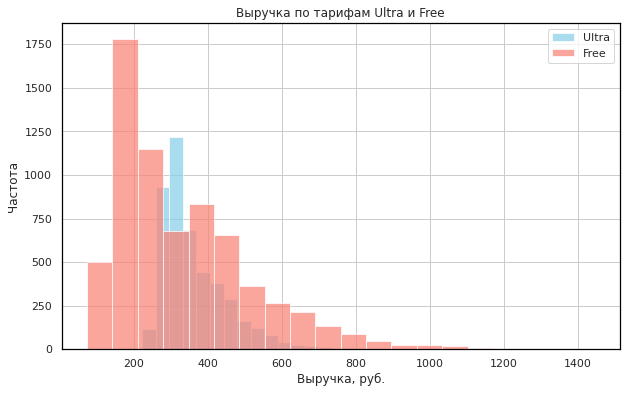

In [97]:
revenue_ultra = revenue_calc[revenue_calc['subscription_type'] == 'ultra']['revenue_month']
revenue_free = revenue_calc[revenue_calc['subscription_type'] == 'free']['revenue_month']

plt.figure(figsize=(10, 6))
plt.hist(revenue_ultra, bins=20, color='skyblue', alpha=0.7, label='Ultra')
plt.hist(revenue_free, bins=20, color='salmon', alpha=0.7, label='Free')
plt.title('Выручка по тарифам Ultra и Free')
plt.xlabel('Выручка, руб.')
plt.ylabel('Частота')
plt.legend()
plt.grid(True)
plt.show()

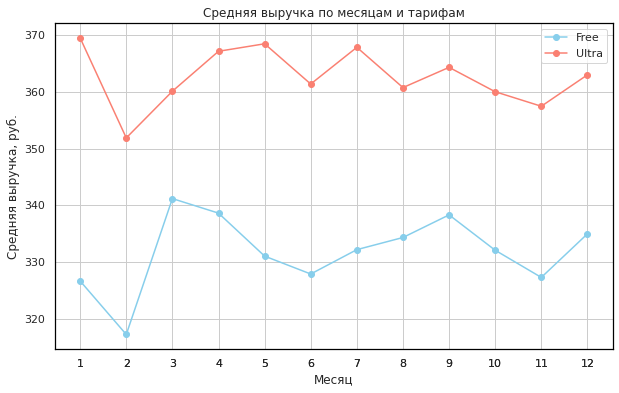

In [98]:
mean_revenue_monthly = revenue_calc.groupby(['month', 'subscription_type'])['revenue_month'].mean().reset_index()

plt.figure(figsize=(10, 6))
plt.plot(mean_revenue_monthly[mean_revenue_monthly['subscription_type'] == 'free']['month'], 
         mean_revenue_monthly[mean_revenue_monthly['subscription_type'] == 'free']['revenue_month'], 
         marker='o', label='Free')


plt.plot(mean_revenue_monthly[mean_revenue_monthly['subscription_type'] == 'ultra']['month'], 
         mean_revenue_monthly[mean_revenue_monthly['subscription_type'] == 'ultra']['revenue_month'], 
         marker='o', label='Ultra')

plt.title('Средняя выручка по месяцам и тарифам')
plt.xlabel('Месяц')
plt.ylabel('Средняя выручка, руб.')
plt.legend()
plt.grid(True)
plt.xticks(mean_revenue_monthly['month'])  # Установка меток по месяцам
plt.show()

#### Вывод

на основании полученного p-value, которое явно меньше выбранного уровня значимости alpha, мы отвергаем нулевую гипотезу. Это означает, что есть статистически значимые доказательства в пользу того, что выручка от пользователей с тарифом Ultra в месяц действительно выше, чем выручка от пользователей с тарифом Free.

### Задание 6.4

 Представьте такую ситуацию: техническая команда сервиса обновила сервера, с которыми взаимодействует мобильное приложение. Она надеется, что из-за этого количество обращений в техподдержку значимо снизилось. Некоторый файл содержит для каждого пользователя данные о количестве обращений до обновления и после него. Какой тест вам понадобился бы для проверки этой гипотезы?

<p>Для проверки предположения о том, что обновление серверов привело к существенному снижению количества обращений в техподдержку, мы можем воспользоваться статистическим тестом на сравнение средних значений двух связанных выборок. В данном случае, связанными выборками будут данные об обращениях каждого пользователя до и после обновления.</p>

<p>Таким образом, проведение парного t-теста позволит проверить гипотезу о том, что среднее количество обращений до обновления серверов равно среднему количеству обращений после обновления. Если полученное значение p-value будет меньше заданного уровня значимости, мы сможем сделать вывод о статистической значимости различий в количестве обращений до и после обновления серверов.</p>

<p>Метод, который нужно использовать при сравнении:&nbsp;<code>scipy.stats.ttest_rel()</code></p>

<p>Гипотезы будут сформулированы так:</p>

<p>H0 :&nbsp;средние значения количество обращений в техподдержку <strong>до </strong> изменения <strong>= </strong>средние значения количество обращений в техподдержку <strong>после </strong>изменения.</p>

<p>H1 : средние значения количество обращений в техподдержку <strong>до </strong> изменения <strong>></strong> средние значения количество обращений в техподдержку <strong>после </strong>изменения.</p>

<p>&nbsp;</p>


## Шаг 7. Распределения

### Задание 7.1

У нас есть независимое испытание - предидущая рассылка промокодов, которое имеет два исхода подписка продлена или нет.

Для решения этой задачи мы можем воспользоваться биномиальным распределением, так как оно подходит для моделирования ситуации. 

Мы знаем, что вероятность продления подписки после бесплатного пробного периода составляет 10%
Нам нужно найти минимальное количество промокодов, чтобы вероятность не выполнить - чтобы менее 100 пользователей продлили подписку, составила примерно 5%.

Будем использовать биномиальное распределение для этой задачи и подоберем подходящее значение параметра 
N с помощью графиков и функции распределения.

Функция binom.cdf(k, n, p) возвращает вероятность того, что случайная величина, описанная биномиальным распределением, примет значение, не превосходящее k. 
n - количество независимых испытаний (количество промокодов в нашем случае)
p - вероятность успеха в каждом испытании (вероятность продления подписки)
k - количество успехов (минимальное количество продлений подписки, которое мы хотим достичь).

binom.cdf(target_subscriptions - 1, n, p) вычисляет вероятность того, что количество успешных событий (продления подписок) не превысит целевое количество target_subscriptions, при условии, что мы разослали n промокодов.

In [99]:



p = 0.1  
target_probability = 0.05  
target_subscriptions = 100  

def calculate_p(n):
    return binom.cdf(target_subscriptions - 1, n, p)

n_values = np.arange(1, 3000, 1)  
failure_probabilities = [calculate_p(n) for n in n_values]

closest_index = np.argmin(np.abs(np.array(failure_probabilities) - target_probability))

optimal_n = n_values[closest_index]

print("Минимальное количество промокодов:", optimal_n)


Минимальное количество промокодов: 1161


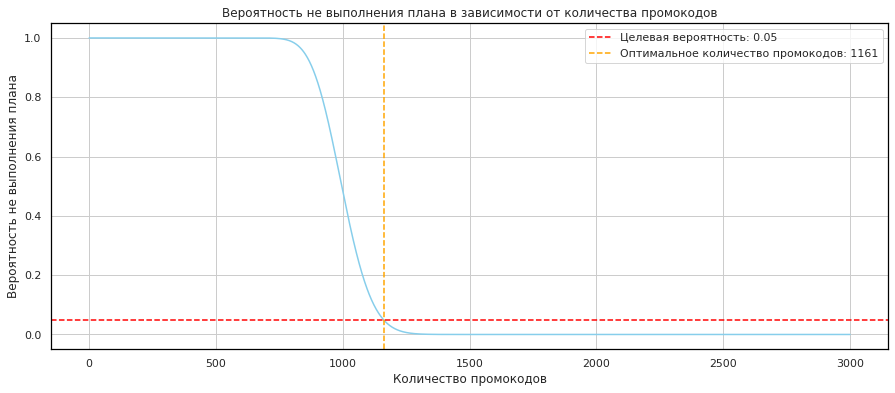

In [100]:
plt.figure(figsize=(15, 6))
plt.plot(n_values, failure_probabilities)
plt.axhline(target_probability, color='red', linestyle='--', label=f'Целевая вероятность: {target_probability}')
plt.axvline(optimal_n, color='orange', linestyle='--', label=f'Оптимальное количество промокодов: {optimal_n}')
plt.title('Вероятность не выполнения плана в зависимости от количества промокодов')
plt.xlabel('Количество промокодов')
plt.ylabel('Вероятность не выполнения плана')
plt.legend()
plt.grid(True)
plt.show()

### Задание 7.2

Отдел маркетинга рассылает клиентам push-уведомления в мобильном приложении. Клиенты могут открыть его или не открывать. Известно, что уведомления открывают около 
40% получивших клиентов. Отдел планирует разослать 1 млн уведомлений. С помощью аппроксимации постройте примерный график распределения и оцените вероятность того, что уведомление откроют не более 
399,5 тыс. пользователей.

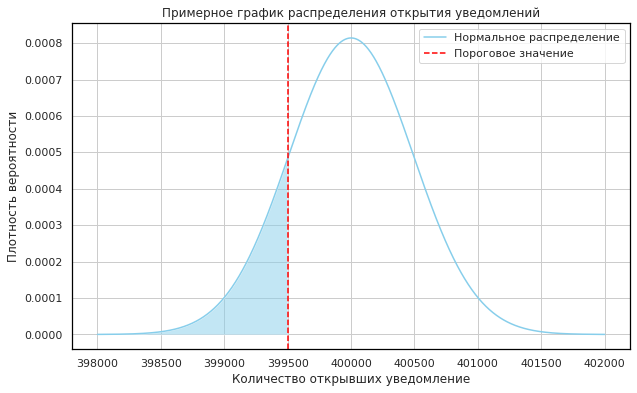

Вероятность того, что уведомление откроют не более 399,5 тыс. пользователей: 0.15371708296369768


In [101]:

n = 1000000  # количество уведомлений
p = 0.4  # вероятность того, что пользователь откроет уведомление
mu = n * p  # среднее значение
sigma = np.sqrt(n * p * (1 - p))  # стандартное отклонение


x = np.linspace(398000, 402000, 1000)
pdf = norm.pdf(x, mu, sigma)

plt.figure(figsize=(10, 6)) 
plt.plot(x, pdf, label='Нормальное распределение')

# Вероятность того, что уведомление откроют не более 399,5 тыс. пользователей
x_limit = 399500
z = (x_limit - mu) / sigma  # стандартизированное значение
probability = norm.cdf(z)

plt.fill_between(x, pdf, where=(x <= x_limit), alpha=0.5)

plt.axvline(x=x_limit, color='red', linestyle='--', label='Пороговое значение')
plt.xlabel('Количество открывших уведомление')
plt.ylabel('Плотность вероятности')
plt.title('Примерное график распределения открытия уведомлений')
plt.legend()
plt.grid(True)
plt.show()


print("Вероятность того, что уведомление откроют не более 399,5 тыс. пользователей:", probability)


### Шаг 7. Общий вывод



<p><strong>Загрузка и анализ данных:</strong></p>

<ul>
	<li>Данные были успешно загружены и проанализированы.</li>
	<li>Оптимизированы типы данных для экономии памяти.</li>
	<li>Обнаружено и удалено небольшое колличество&nbsp;дубликатов.</li>
	<li>Выявлены и обработаны пропуски данных.</li>
</ul>

<p><strong>География и распределение пользователей</strong>:</p>

<ul>
	<li>География представлена восьмью городами, с распределением примерно равными частями.</li>
	<li>Наибольшее количество пользователей зарегистрировано в Пятигорске(226), а наименьшее - в Москве(172).</li>
</ul>

<p><strong>Характеристики поездок</strong>:</p>

<ul>
	<li>Основное расстояние поездки составляет от 2 до 4.5 км, среднее расстояние - 3 км, максимальное - 7.2 км.</li>
	<li>Основное время поездки составляет от 10 до 27 минут, среднее время - 18 минут, максимальное - 46.6 минут.</li>
	<li>Самое большое количество поездок (27) было совершено одним пользователем на расстояние 78.7 км с общим временем в 446 минут.</li>
	<li>Меньше всего поездок (2) было у двух пользователей на расстояние 5.5 и 5.6 км с временем 44 и 36 минут соответственно.</li>
</ul>

<p><strong>Возрастной состав пользователей</strong>:</p>

<ul>
	<li>Основной возраст пользователей находится в диапазоне от 20 до 30 лет.</li>
	<li>Средний возраст пользователей составляет 25 лет, с минимальным значением в 12 лет и максимальным в 43 года.</li>
	<li>Обнаружено 79 пользователей младше 18 лет, что не соответствует правилам большинства прокатов, требующих регистрацию только лиц старше 18 лет.</li>
	<li>Платную подписку предпочетают больше люди в возврасте 19, 29, 31, 32, 33, 35 лет</li>
</ul>

<p><strong>Активность пользователей разных тарифов:</strong></p>

<ul>
	<li>Поездки на тарифе &#39;free&#39; составляют 64.0%, в то время как на тарифе &#39;ultra&#39; - 36.0%. Это означает, что количество поездок на тарифе &#39;free&#39; больше, чем на тарифе &#39;ultra&#39;.</li>
	<li>Количество пользователей, выбравших тариф &#39;free&#39;, составляет 54%, в то время как тариф &#39;ultra&#39; выбрали 46% пользователей.</li>
	<li>Тариф &#39;free&#39; привлекает больше пользователей, их средняя активность в виде количества поездок на одного пользователя оказывается выше, чем у пользователей тарифа &#39;ultra&#39;. в 1.7 раз, не смотря на то что люди платят абонентскую плату, ездят меньше.</li>
	<li>Но на тарифе Free общее расстояние и время не значительно меньше, чем у людей на тарифе Ultra.</li>
	<li>Free&nbsp;минималные показатели 2.04 минуты, а расстояние&nbsp;0.86 метра, а максимальные 46.56 минут и&nbsp;7211 метров.&nbsp; В среднем 17.63 минут и 3045&nbsp;метров</li>
	<li>Ultra&nbsp; минималные показатели 3.76 минуты, а расстояние&nbsp;244 метра, а максимальные 40 минут и&nbsp;5699 метров.&nbsp; В среднем 18.54 минут и&nbsp;3115 метров</li>
</ul>

<p><strong>Проверка гипотез:</strong></p>

<ul>
	<li>У нас есть статистически значимые доказательства в пользу того, что время пользователей с тарифом Ultra на поездки в среднем больше, чем время пользователей с тарифом Free.</li>
	<li>Расстояние одной поездки в 3130 метров &mdash; оптимальное с точки зрения износа самоката. что у нас достаточно статистических доказательств, чтобы сделать вывод о том, что среднее расстояние за одну поездку на тарифе ультра не превышает 3130</li>
	<li>Есть статистически значимые доказательства в пользу того, что выручка от пользователей с тарифом Ultra в месяц действительно выше, чем выручка от пользователей с тарифом Free.</li>
	<li>В случае если техническая команда сервиса обновит сервера, с которыми взаимодействует мобильное приложение. Мы сможем провести анализ из-за этого количество обращений в техподдержку снизится или останется преждним.&nbsp;</li>
</ul>

<p><strong>Ответы на вопросы отдела маркетинга:</strong></p>

<ul>
	<li>
	<pre>
Если отделу маркетинга GoFast нужно провести акцию с раздачей промокодов на один бесплатный месяц подписки, в рамках которой как минимум 100 существующих клиентов должны продлить эту подписку - Минимальное количество промокодов: 1161</pre>
	</li>
	<li>
	<pre>
Если отдел маркетинга  планирует разослать 1 млн уведомлений. Вероятность того, что уведомление откроют не более 399,5 тыс. пользователей 15%</pre>
	</li>
</ul>

<p>&nbsp;</p>

<p><strong>Рекомендации:</strong></p>

<ul>
	<li>Данная выборка достаточно однородна, и не позволит сделать анализ по распределение активности по месяцам в разных городах, так как колличество примерно одинаковое по месяцам и городам, а сезоны разные</li>
	<li>Надо разобраться с людьми до 18 лет, это категория людей с повышенным риском</li>
	<li>При выгрузки данных нужны уточнения для пользователей (фамилия, дата рождения)</li>
	<li>Сервису не хватает страховки за поездку</li>
	<li>Сервису не хватает дневных тарифов и тарифов с расстоянием</li>
</ul>
